## Training Deep Neural Networks

1. Vanishing / Exploding Gradients
    - Xavier (Glorot) and He Initialiation (custom kernel_init)
    - non-saturational activation (leaky-ReLU, Parametric and Random leaky, Elu, Scaled Relu)
    - Batch-Normalization (add before/after activ. no standardization needed, fixup Initial 2019 maybe obsolete ?
    - Gradient Clipping (clip_norm/-value, for RNN since no BN)
    
2. Reusing pretrained Layers

- 
3. Faster Optimizers
4. Avoiding Overfitting Through Regularization
5. Summary and Practical Guidelines


In [1]:
## Setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. Vanishing / Exploding Gradients

resaon : all take sigmoid activation (since Mother Nature is using it in biol. neurons :D)

- graphical explanation - saturation at the tails

    

Saving figure sigmoid_saturation_plot


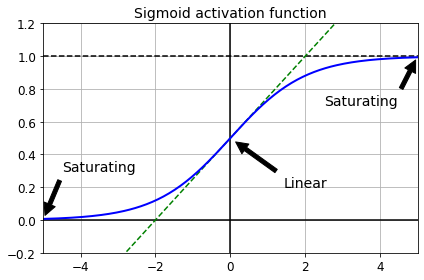

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier (Glorot) and He Initializations

- initialization and different activation eliminates van./expl. Gradients risk



In [5]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [7]:
keras.layers.Dense(300, activation='relu', kernel_initializer="he_normal") # or he_uniform - same

In [8]:
# customize initializer

init = keras.initializers.VarianceScaling(scale=2, mode="fan_avg",
                                         distribution="uniform")

keras.layers.Dense(300, activation='relu', kernel_initializer=init)


In [ ]:
## Non-Saturating Activiation Functions

- leaky relu
- parametric leaky rectified linear unit
- randomized relu
- elu
- scaled elu
- 

Saving figure leaky_relu_plot


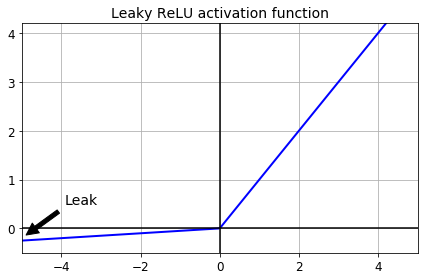

In [9]:
# leaky Relu

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [10]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [11]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [2]:
# NN with leaky relu and He Normal Initializer

# data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# set up model

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

#compile and train

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
# train

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 9s 163us/sample - loss: 1.3151 - accuracy: 0.5922 - val_loss: 0.9042 - val_accuracy: 0.7200
Epoch 2/10
55000/55000 [==============================] - 7s 135us/sample - loss: 0.8140 - accuracy: 0.7349 - val_loss: 0.7240 - val_accuracy: 0.7686
Epoch 3/10
55000/55000 [==============================] - 8s 138us/sample - loss: 0.6911 - accuracy: 0.7767 - val_loss: 0.6408 - val_accuracy: 0.7946
Epoch 4/10
55000/55000 [==============================] - 8s 153us/sample - loss: 0.6256 - accuracy: 0.7968 - val_loss: 0.5900 - val_accuracy: 0.8116
Epoch 5/10
55000/55000 [==============================] - 8s 153us/sample - loss: 0.5837 - accuracy: 0.8100 - val_loss: 0.5589 - val_accuracy: 0.8182
Epoch 6/10
55000/55000 [==============================] - 7s 135us/sample - loss: 0.5552 - accuracy: 0.8166 - val_loss: 0.5340 - val_accuracy: 0.8284
Epoch 7/10
55000/55000 [===========================

Saving figure elu_plot


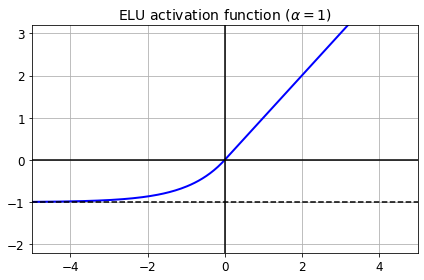

In [15]:
## ELU

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [17]:
keras.layers.Dense(10, activation="elu")

### SELU (scaled exponential linear unit)

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [12]:
# plot the SELU activation function

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()


NameError: name 'z' is not defined

In [14]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

## Batch Normalization


- for or after activation - if before, no bias neuron needed
- in diagramms often omitted since considered standard
- fixup initialization maybe makes BN obsolete ?
- no standardScaler needed since scales and shifts mini_batch input
- gamma, beta and mu (mean) and sigma (standard deviation)m


In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

# 4 variables per BN layer (gamma, beta, mu, and sigma)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [25]:
# cheack which parameters of BN are trainable by the Gradient Descent

bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [26]:
# applying BN before activation (use_bias = False)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 9s 170us/sample - loss: 1.0468 - accuracy: 0.6830 - val_loss: 0.6881 - val_accuracy: 0.7962
Epoch 2/10
55000/55000 [==============================] - 8s 146us/sample - loss: 0.6847 - accuracy: 0.7853 - val_loss: 0.5656 - val_accuracy: 0.8200
Epoch 3/10
55000/55000 [==============================] - 8s 142us/sample - loss: 0.5971 - accuracy: 0.8057 - val_loss: 0.5065 - val_accuracy: 0.8388
Epoch 4/10
55000/55000 [==============================] - 8s 142us/sample - loss: 0.5491 - accuracy: 0.8177 - val_loss: 0.4716 - val_accuracy: 0.8462
Epoch 5/10
55000/55000 [==============================] - 8s 141us/sample - loss: 0.5123 - accuracy: 0.8270 - val_loss: 0.4482 - val_accuracy: 0.8554
Epoch 6/10
55000/55000 [==============================] - 9s 156us/sample - loss: 0.4940 - accuracy: 0.8311 - val_loss: 0.4302 - val_accuracy: 0.8580
Epoch 7/10
55000/55000 [===========================

## 10. 3. Gradient Clipping
    
    - all optimizer accept clipnorm/ -value
    - input vector [0.002, 1000] becomes [0.002, 1] w clipvalue=1
    - direction of input vector might change with clipvalue
    

    

In [ ]:
optimizer = keras.optimizers.SGD(lr = 1e-3, clipnorm = 1)



In [ ]:
Ch. 10.1 Vanishing / Exploding Gradients 
    - Xavier Glorot, He, LeChun Initialization
    - Non-Saturating Activation (Selu, leaky, etc)
    - BN (fixup initialization 2019)
    

## 11. 2. Reusing Pretrained Models

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [3]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
## set up both models A and B (so we have reference values ) afterwards transfer Model A to B

# Model A
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 8s 174us/sample - loss: 0.5902 - accuracy: 0.8133 - val_loss: 0.3782 - val_accuracy: 0.8692
Epoch 2/20
43986/43986 [==============================] - 7s 154us/sample - loss: 0.3518 - accuracy: 0.8783 - val_loss: 0.3370 - val_accuracy: 0.8839
Epoch 3/20
43986/43986 [==============================] - 8s 174us/sample - loss: 0.3163 - accuracy: 0.8896 - val_loss: 0.3019 - val_accuracy: 0.8956
Epoch 4/20
43986/43986 [==============================] - 7s 162us/sample - loss: 0.2969 - accuracy: 0.8973 - val_loss: 0.2912 - val_accuracy: 0.9013
Epoch 5/20
43986/43986 [==============================] - 7s 157us/sample - loss: 0.2831 - accuracy: 0.9027 - val_loss: 0.2816 - val_accuracy: 0.9016
Epoch 6/20
43986/43986 [==============================] - 7s 168us/sample - loss: 0.2725 - accuracy: 0.9065 - val_loss: 0.2736 - val_accuracy: 0.9073
Epoch 7/20
43986/43986 [===========================

In [6]:
model_A.save("my_model_A.h5")

In [30]:
# set up Model B (same parameters as Model A except loss= binary_crossentrophy)

model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 4ms/sample - loss: 0.5480 - accuracy: 0.7400 - val_loss: 0.4336 - val_accuracy: 0.8398
Epoch 2/20
200/200 [==============================] - 0s 527us/sample - loss: 0.3962 - accuracy: 0.8550 - val_loss: 0.3488 - val_accuracy: 0.8905
Epoch 3/20
200/200 [==============================] - 0s 500us/sample - loss: 0.3174 - accuracy: 0.8800 - val_loss: 0.2926 - val_accuracy: 0.9158
Epoch 4/20
200/200 [==============================] - 0s 465us/sample - loss: 0.2610 - accuracy: 0.9250 - val_loss: 0.2527 - val_accuracy: 0.9361
Epoch 5/20
200/200 [==============================] - 0s 466us/sample - loss: 0.2224 - accuracy: 0.9600 - val_loss: 0.2218 - val_accuracy: 0.9544
Epoch 6/20
200/200 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.96 - 0s 472us/sample - loss: 0.1909 - accuracy: 0.9700 - val_loss: 0.1973 - val_accuracy: 0.9635
Epoch 7/20
200/200 [==================

In [7]:
# transfer model A to B 

model_A = keras.models.load_model('my_model_A.h5')

# all layers except output layer
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])

# add output layer for binary classification on model B
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))


# WATCH OUT ! any time you train Model B_on_A model A will be changed too!

# Better clone (but don't forget the set_weights since those not included with clone_model())

model_A_clone = keras.models.clone_model(model_A)

model_A_clone.set_weights(model_A.get_weights())


In [8]:
# freeze layers 

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
# after change always need to COMPILE AGAIN 

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 1s 5ms/sample - loss: 0.1942 - accuracy: 0.9600 - val_loss: 0.2095 - val_accuracy: 0.9726
Epoch 2/4
200/200 [==============================] - 0s 657us/sample - loss: 0.1885 - accuracy: 0.9600 - val_loss: 0.2044 - val_accuracy: 0.9726
Epoch 3/4
200/200 [==============================] - 0s 744us/sample - loss: 0.1834 - accuracy: 0.9600 - val_loss: 0.1995 - val_accuracy: 0.9746
Epoch 4/4
200/200 [==============================] - 0s 673us/sample - loss: 0.1785 - accuracy: 0.9600 - val_loss: 0.1947 - val_accuracy: 0.9767
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 6ms/sample - loss: 0.1655 - accuracy: 0.9650 - val_loss: 0.1695 - val_accuracy: 0.9817
Epoch 2/16
200/200 [==============================] - 0s 843us/sample - loss: 0.1418 - accuracy: 0.9750 - val_loss: 0.1517 - val_accuracy: 0.9828
Epoch 3/16
200/200 [====================

In [9]:
model_B.evaluate(X_test, y_test)

NameError: name 'model_B' is not defined

In [ ]:
model_B_on_A.evaluate(X_test, y_test)


## Faster Optimizers

- Momentum Optimizer (nesterov)

optimizer = keras.optimizers.SGD(lr=0.001, momentum = 0.9, nesterov=]True)

- AdaGrad

keras.optimizers.Adagrad(lr=0.001)

- RMSProp

- Adam and Nadam

keras.optimizers.Adam(lr= 0.001, beta_1= 0.9, beta_2 = 0.999)

.Nadam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [ ]:
## Learning Rate Scheduling

- Power Scheduling

- Exponential Scheduling

In [15]:
# Exponential

#lr = lr0 * 0.1**(epoch / s)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

# get the exponential fuction into LearningRateScheduler() of keras.callbacks

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])



Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 15s 276us/sample - loss: 0.8450 - accuracy: 0.7559 - val_loss: 1.0001 - val_accuracy: 0.6830
Epoch 2/25
55000/55000 [==============================] - 14s 252us/sample - loss: 0.7001 - accuracy: 0.7842 - val_loss: 0.6712 - val_accuracy: 0.8162
Epoch 3/25
55000/55000 [==============================] - 13s 230us/sample - loss: 0.6237 - accuracy: 0.8139 - val_loss: 0.7257 - val_accuracy: 0.7668
Epoch 4/25
55000/55000 [==============================] - 13s 233us/sample - loss: 0.5778 - accuracy: 0.8272 - val_loss: 0.6870 - val_accuracy: 0.7704
Epoch 5/25
55000/55000 [==============================] - 12s 221us/sample - loss: 0.5301 - accuracy: 0.8431 - val_loss: 0.5183 - val_accuracy: 0.8474
Epoch 6/25
55000/55000 [==============================] - 13s 238us/sample - loss: 0.4653 - accuracy: 0.8573 - val_loss: 0.5665 - val_accuracy: 0.8612
Epoch 7/25
55000/55000 [=====================

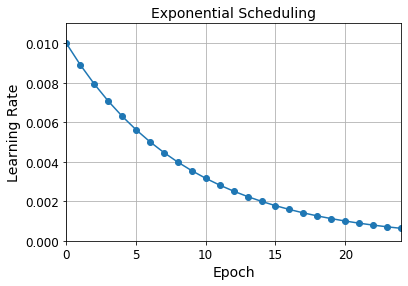

In [16]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Learning Rate (per batch)

### Pieacewise Constant Scheduling 

- lots of manual fiddling to get good values


In [ ]:

def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
    


In [17]:
## Performance Scheduling

keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience= 5)


In [18]:
### tf.keras schedulers

# special schedulers in tf.keras only

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 9s 156us/sample - loss: 0.4842 - accuracy: 0.8318 - val_loss: 0.4174 - val_accuracy: 0.8556
Epoch 2/25
55000/55000 [==============================] - 8s 147us/sample - loss: 0.3787 - accuracy: 0.8648 - val_loss: 0.3772 - val_accuracy: 0.8688
Epoch 3/25
55000/55000 [==============================] - 8s 151us/sample - loss: 0.3451 - accuracy: 0.8768 - val_loss: 0.3684 - val_accuracy: 0.8700
Epoch 4/25
55000/55000 [==============================] - 8s 141us/sample - loss: 0.3235 - accuracy: 0.8842 - val_loss: 0.3519 - val_accuracy: 0.8776
Epoch 5/25
55000/55000 [==============================] - 8s 144us/sample - loss: 0.3067 - accuracy: 0.8910 - val_loss: 0.3438 - val_accuracy: 0.8818
Epoch 6/25
55000/55000 [==============================] - 8s 148us/sample - loss: 0.2942 - accuracy: 0.8945 - val_loss: 0.3414 - val_accuracy: 0.8814
Epoch 7/25
55000/55000 [===========================

In [19]:
# for piecewise constant scheduling

learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])



NameError: name 'n_steps_per_epoch' is not defined

In [ ]:
## 1Cycle Scheduling



### 11.1.4 Avoiding Overfitting through regularization

1. l1 and l2 Regularization <br>
    - in layers.Dense(...., kernel_init = ..., kernel_regularizer = keras.ergularizers.l2(0.01)))
    

2. Dropout <br>
    - add layers.Dropout(rate=0.2) after .Dense()
    - make neurons inactive (outputs zero)
    - destructive technique but better results - in daily work life too ? randomly send workers home every morning ?

3. MonteCarlo Dropout

4. MaxNorm

## Exercise :

No. 8 Deep Learning on CIFAR10

- build DNN with 20 hidden layers, 100 neurons He_uniform and activation="elu"


In [21]:
### setup

import tensorflow as tf

# clear backend cache
keras.backend.clear_session()

# for reproducability set seed(42)
tf.random.set_seed(42)
np.random.seed(42)




## NO. 8 a) build model 

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3])) # 32 x 32 pixels and 3 for colors

for layer in range(20):
    model.add(keras.layers.Dense(100, 
                       activation="elu",
                      kernel_initializer= "he_normal"))
    
## No. 8 b)

# add output layer to model (since 10 classes softmax function)
model.add(keras.layers.Dense(10, activation = "softmax"))

# get data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

# split train set in valid set ?
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

#  - Compile(opti = Nadam, etc )
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.Nadam(lr=5e-5, beta_1 = 0.9, beta_2 = 0.99),
              metrics = ["accuracy"]
             )
#  define callbacks
early_stopping = keras.callbacks.EarlyStopping(patience = 5,)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5",  save_best_only= True)

run_index = 1 # ALWAYS INCREMENT manually !!!!!!!!!!!!!1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



170500096/170498071 [==============================] - 201s 1us/step


In [22]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 16136.

In [ ]:
model.fit(X_train, y_train, epochs=20,
         validation_data=(X_valid, y_valid),
         callbacks = [early_stopping, model_checkpoint, tensorboard_cb])

In [23]:
## Exercise 8 c)


keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


# 1) build the same Model with BN 
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3])) # 32 x 32 pixels and 3 for colors

# first BN (for regularization)
model.add(keras.layers.BatchNormalization())

# for each hidden layer a BN (since after Dense Layer, Activation muss be seperated)
for layer in range(20):
    model.add(keras.layers.Dense(100,
                      kernel_initializer= "he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
    
# last output layer same 
model.add(keras.layers.Dense(10, activation="softmax"))

# 2) compile, callbacks, and training same (except different name for logs)

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

# 3) load the best model and evaluate

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_test, y_test)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 53s 1ms/sample - loss: 1.8487 - accuracy: 0.3380 - val_loss: 1.6449 - val_accuracy: 0.4122
Epoch 2/100
45000/45000 [==============================] - 35s 772us/sample - loss: 1.6679 - accuracy: 0.4053 - val_loss: 1.5977 - val_accuracy: 0.4248
Epoch 3/100
45000/45000 [==============================] - 36s 798us/sample - loss: 1.5985 - accuracy: 0.4314 - val_loss: 1.5244 - val_accuracy: 0.4512
Epoch 4/100
45000/45000 [==============================] - 36s 791us/sample - loss: 1.5461 - accuracy: 0.4506 - val_loss: 1.4796 - val_accuracy: 0.4734
Epoch 5/100
45000/45000 [==============================] - 35s 788us/sample - loss: 1.5099 - accuracy: 0.4643 - val_loss: 1.4376 - val_accuracy: 0.4904
Epoch 6/100
45000/45000 [==============================] - 36s 791us/sample - loss: 1.4709 - accuracy: 0.4793 - val_loss: 1.4287 - val_accuracy: 0.4870
Epoch 7/100
45000/45000 [================

[1.3459499521255494, 0.5268]

In [ ]:
## Exercise 8 d)

# lecun initialization, no BN, "selu" and standardize data = (x - mean) / std
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# 1) model

model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape= [32, 32, 3]))

for layer in range(20):
    model.add(keras.layers.Dense(100, kernel_initialization = 'lecun_normal',
                                activation = 'selu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

optimizer = keras.optimizer.Nadam(lr = 7e-4)
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
# callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# standardize values

x_mean = X_train.mean(axis=0)
x_std = X_train.std(axis=0)

X_train_scaled = (X_train - x_mean )/ x_std
X_valid_scaled = (X_valid - x_mean) / x_std
X_test_scaled = (X_test - x_mean ) / x_std


# train model 

model.fit(X_train_scaled, y_train, epochs=100,
         validation_data = (X_valid, y_valid),
         callbacks = callbacks)

# get best model and evaluate

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate()

In [ ]:
## 8 e.)

# use AlphaDropout

# just add .... in for loop

model.add(keras.layers.AlphaDropout(rate=0.2)) 